# Esports Dynamics: Predictive Analytics in League of Legends Leagues

**Name(s)**: Sophie Wang

**Website Link**: https://sophie-wzr.github.io/League-of-legends-analysis/

In [2]:
import pandas as pd
import numpy as np
from pathlib import Path

import plotly.express as px
pd.options.plotting.backend = 'plotly'

import plotly.io as pio
pio.renderers.default = 'notebook'

from dsc80_utils import *

## Step 1: Introduction

As an esports enthusiast and a league player, we want to investigates the competitive dynamics of professional esports leagues for League of Legends, specifically focusing on tier-one leagues, LPL, LCK, LEC, and LCS. \
The central question of our study is: Which tier-one league delivers the most “action-packed” games based on player performance statistics?

## Step 2: Data Cleaning and Exploratory Data Analysis

In [3]:
file_path = '2022_LoL_esports_match_data_from_OraclesElixir.csv'
df = pd.read_csv(file_path, low_memory = False)
df

gameid datacompleteness  \
0       ESPORTSTMNT01_2690210         complete   
1       ESPORTSTMNT01_2690210         complete   
2       ESPORTSTMNT01_2690210         complete   
...                       ...              ...   
150177       9687-9687_game_5          partial   
150178       9687-9687_game_5          partial   
150179       9687-9687_game_5          partial   

                                                url league  ...  deathsat25  \
0                                               NaN   LCKC  ...         1.0   
1                                               NaN   LCKC  ...         2.0   
2                                               NaN   LCKC  ...         0.0   
...                                             ...    ...  ...         ...   
150177  https://lpl.qq.com/es/stats.shtml?bmid=9687   DCup  ...         NaN   
150178  https://lpl.qq.com/es/stats.shtml?bmid=9687   DCup  ...         NaN   
150179  https://lpl.qq.com/es/stats.shtml?bmid=9687   DCup  ...         NaN   

       opp_killsat25  opp_assistsat25 opp_deathsat25  
0                0.0              2.0            0.0  
1                1.0              5.0            1.0  
2                3.0              4.0            3.0  
...              ...              ...            ...  
150177           NaN              NaN            NaN  
150178           NaN              NaN            NaN  
150179           NaN              NaN            NaN  

[150180 rows x 161 columns]

In [4]:
df_tier_one = df[df['league'].isin(['LPL', 'LCK', 'LEC', 'LCS'])]

# Filter out rows where the 'position' column is equal to 'team'
df_tier_one_filtered = df_tier_one[df_tier_one['position'] == 'team']

# Select relevant columns
df_tier_one_filtered = df_tier_one_filtered[['gameid', 'league', 
                                             'team kpm', 'dpm', 
                                             'url', 'side']]

# Group by 'gameid' and aggregate numerical columns
df_tier_one_filtered = df_tier_one_filtered.groupby('gameid').agg({
    'league': 'first',  # Take the first value of 'league' as all rows within a game have the same league
    'team kpm': 'sum',  # Sum up 'team kpm' for the game
    'dpm': 'sum',       # Sum up 'dpm' for the game
    'url': 'first',
    'side': 'first' # Take the first URL (assuming URLs are consistent for a game)
})

# Rename columns for clarity
df_tier_one_filtered = df_tier_one_filtered.rename(columns={
    'team kpm': 'game kpm',
    'dpm': 'game dpm'
})

df_tier_one_filtered

league  game kpm  game dpm  \
gameid                                             
8401-8401_game_1         LPL      0.84   3099.03   
8401-8401_game_2         LPL      1.25   3942.17   
8402-8402_game_1         LPL      0.63   3251.22   
...                      ...       ...       ...   
ESPORTSTMNT06_2542222    LCK      1.00   4962.60   
ESPORTSTMNT06_2542223    LCK      0.59   3596.54   
ESPORTSTMNT06_2542228    LCK      0.47   3424.84   

                                                               url  side  
gameid                                                                    
8401-8401_game_1       https://lpl.qq.com/es/stats.shtml?bmid=8401  Blue  
8401-8401_game_2       https://lpl.qq.com/es/stats.shtml?bmid=8401  Blue  
8402-8402_game_1       https://lpl.qq.com/es/stats.shtml?bmid=8402  Blue  
...                                                            ...   ...  
ESPORTSTMNT06_2542222                                         None  Blue  
ESPORTSTMNT06_2542223                                         None  Blue  
ESPORTSTMNT06_2542228                                         None  Blue  

[1802 rows x 5 columns]

In [5]:
!pip install tabulate
print(df_tier_one_filtered.head().to_markdown(index=False))

| league   |   game kpm |   game dpm | url                                         | side   |
|:---------|-----------:|-----------:|:--------------------------------------------|:-------|
| LPL      |     0.8351 |    3099.03 | https://lpl.qq.com/es/stats.shtml?bmid=8401 | Blue   |
| LPL      |     1.2465 |    3942.17 | https://lpl.qq.com/es/stats.shtml?bmid=8401 | Blue   |
| LPL      |     0.6339 |    3251.22 | https://lpl.qq.com/es/stats.shtml?bmid=8402 | Blue   |
| LPL      |     0.502  |    3568.48 | https://lpl.qq.com/es/stats.shtml?bmid=8402 | Blue   |
| LPL      |     0.8526 |    3633.66 | https://lpl.qq.com/es/stats.shtml?bmid=8402 | Blue   |


In [6]:
pivot_table = df_tier_one_filtered.pivot_table(
    values=['game kpm', 'game dpm'],
    index='league',
    aggfunc=['mean', 'max']
)
pivot_table
print(pivot_table.to_markdown(index=False))

|   ('mean', 'game dpm') |   ('mean', 'game kpm') |   ('max', 'game dpm') |   ('max', 'game kpm') |
|-----------------------:|-----------------------:|----------------------:|----------------------:|
|                3812.21 |               0.700287 |               6683.95 |                1.5611 |
|                3896.39 |               0.733368 |               7352.5  |                1.3486 |
|                4090.73 |               0.804023 |               6818.34 |                1.6043 |
|                4052.46 |               0.839326 |               6840.96 |                1.9029 |


In [7]:
# Histogram for 'game dpm' conditioned on 'league'
fig_dpm = px.histogram(
    df_tier_one_filtered, 
    x='game dpm', 
    nbins=30, 
    #color='league', 
    title='Histogram of DPM per game (Damage Per Minute)',
    category_orders={'league': ['LCK', 'LPL', 'LEC', 'LCS']}  # Ensuring order of leagues
)
fig_dpm.update_layout(
    xaxis_title='Game DPM', 
    yaxis_title='Frequency', 
    barmode='overlay'  # Overlay the histograms
)
fig_dpm.update_traces(opacity=0.7)  # Set opacity for the bars
fig_dpm.show(renderer="iframe")
fig_dpm.write_html("dpm_histogram_uni.html", include_plotlyjs="cdn")

In [8]:
# Histogram for 'game dpm' conditioned on 'league'
fig_dpm = px.histogram(
    df_tier_one_filtered, 
    x='game dpm', 
    nbins=30, 
    color='league', 
    title='Histogram of DPM per game (Damage Per Minute) by League',
    category_orders={'league': ['LCK', 'LPL', 'LEC', 'LCS']}  # Ensuring order of leagues
)
fig_dpm.update_layout(
    xaxis_title='Game DPM', 
    yaxis_title='Frequency', 
    barmode='overlay'  # Overlay the histograms
)
fig_dpm.update_traces(opacity=0.7)  # Set opacity for the bars
fig_dpm.show(renderer="iframe")
fig_dpm.write_html("dpm_histogram.html", include_plotlyjs="cdn")

In [9]:
# Histogram for 'game kpm' conditioned on 'league'
fig_kpm = px.histogram(
    df_tier_one_filtered, 
    x='game kpm', 
    nbins=30, 
    color='league', 
    title='Histogram of KPM per game (Kills Per Minute) by League',
    category_orders={'league': ['LCK', 'LPL', 'LEC', 'LCS']}  # Ensuring order of leagues
)
fig_kpm.update_layout(
    xaxis_title='Game KPM', 
    yaxis_title='Frequency', 
    barmode='overlay'  # Overlay the histograms
)
fig_kpm.update_traces(opacity=0.7)  # Set opacity for the bars
fig_kpm.show(renderer="iframe")
fig_kpm.write_html("kpm_histogram.html", include_plotlyjs="cdn")

In [10]:
# Select only the relevant columns for analysis of action metrics: 'league', 'dpm', and 'team kpm'
df_action_metrics = df_tier_one[['league', 'dpm', 'team kpm']]

# Check for missing values in the 'dpm' and 'team kpm' columns
missing_metrics_data = df_action_metrics.isnull().mean() * 100

# Display missing data percentages for verification
missing_metrics_data

league      0.0
dpm         0.0
team kpm    0.0
dtype: float64

In [11]:
import plotly.express as px

# Create a scatter plot with Plotly for bivariate analysis
fig = px.scatter(
    df_action_metrics,
    x='dpm',
    y='team kpm',
    color='league',
    title='Bivariate Analysis: DPM vs Team KPM by League',
    labels={'dpm': 'DPM (Damage per Minute)', 'team kpm': 
            'Team KPM (Kills per Minute)'},
)
fig.show(renderer="iframe")
fig.write_html("scatter_dpm_kpm.html", include_plotlyjs='cdn')

In [12]:
# Bivariate Analysis #2: Scatter plot of `dpm` vs `team kpm` with points colored by league
import seaborn as sns
import matplotlib.pyplot as plt

# Set up the figure for the scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_action_metrics, x='dpm', y='team kpm', 
                hue='league', alpha=0.6)

# Title and labels
plt.title('Bivariate Analysis: DPM vs Team KPM by League')
plt.xlabel('DPM (Damage per Minute)')
plt.ylabel('Team KPM (Kills per Minute)')
plt.legend(title='League', loc='upper right')
plt.show()

## Step 3: Assessment of Missingness

In [15]:
df_tier_one_filtered['url_missing'] = (df_tier_one_filtered['url']
                                        .isnull().astype(int))
df_tier_one_filtered

league  game kpm  game dpm  \
gameid                                             
8401-8401_game_1         LPL      0.84   3099.03   
8401-8401_game_2         LPL      1.25   3942.17   
8402-8402_game_1         LPL      0.63   3251.22   
...                      ...       ...       ...   
ESPORTSTMNT06_2542222    LCK      1.00   4962.60   
ESPORTSTMNT06_2542223    LCK      0.59   3596.54   
ESPORTSTMNT06_2542228    LCK      0.47   3424.84   

                                                               url  side  \
gameid                                                                     
8401-8401_game_1       https://lpl.qq.com/es/stats.shtml?bmid=8401  Blue   
8401-8401_game_2       https://lpl.qq.com/es/stats.shtml?bmid=8401  Blue   
8402-8402_game_1       https://lpl.qq.com/es/stats.shtml?bmid=8402  Blue   
...                                                            ...   ...   
ESPORTSTMNT06_2542222                                         None  Blue   
ESPORTSTMNT06_2542223                                         None  Blue   
ESPORTSTMNT06_2542228                                         None  Blue   

                       url_missing  
gameid                              
8401-8401_game_1                 0  
8401-8401_game_2                 0  
8402-8402_game_1                 0  
...                            ...  
ESPORTSTMNT06_2542222            1  
ESPORTSTMNT06_2542223            1  
ESPORTSTMNT06_2542228            1  

[1802 rows x 6 columns]

In [16]:
df2 = df_tier_one_filtered[['league', 'url', 'url_missing']]
true_missing = df2[df2['url_missing'] == 1]
false_missing = df2[df2['url_missing'] == 0]

In [17]:
fig_true = px.histogram(
    true_missing, 
    x='league', 
    color='league', 
    title='Density Bar Graph of League (missing_url == True)',
    category_orders={'league': ['LCK', 'LPL', 'LEC', 'LCS']}  # Ensuring order of leagues
)

fig_true.update_layout(
    yaxis_title='Density',
    barmode='overlay'  # Overlay the histograms
)
fig_true.show(renderer="iframe")
fig_true.write_html("true_missing.html", include_plotlyjs='cdn')

In [18]:
fig_false = px.histogram(
    false_missing, 
    x='league', 
    color='league', 
    title='Density Bar Graph of League (missing_url == False)',
    category_orders={'league': ['LCK', 'LPL', 'LEC', 'LCS']}  # Ensuring order of leagues
)

fig_false.update_layout(
    yaxis_title='Density',
    barmode='overlay'  # Overlay the histograms
)
fig_false.show(renderer="iframe")
fig_false.write_html("false_missing.html", include_plotlyjs='cdn')

In [24]:
# Create a missingness indicator for the 'url' column
df_tier_one_filtered['url_missing'] = (df_tier_one_filtered['url']
                                       .isnull().astype(int))

def compute_tvd(data, group_col, category_col):
    # Get counts of the category within each group
    counts = data.groupby(group_col)[category_col]\
    .value_counts(normalize=True).unstack(fill_value=0)
    # Calculate the absolute difference in proportions
    tvd = np.sum(np.abs(counts.loc[0] - counts.loc[1])) / 2
    return tvd

# Observed TVD
observed_tvd = compute_tvd(df_tier_one_filtered, 
                           group_col='url_missing', 
                           category_col='league')

# Permutation Test
n_permutations = 1000
perm_tvd_values = np.empty(n_permutations)

df_copy = df_tier_one_filtered.copy()

for i in range(n_permutations):
    # Permute the missingness labels
    df_copy['url_missing'] = np.random.permutation\
    (df_tier_one_filtered['url_missing'])
    # Calculate the TVD for the permuted data
    perm_tvd_values[i] = compute_tvd(df_copy, 
                                     group_col='url_missing', 
                                     category_col='league')

# Calculate p-value
p_value = np.mean(perm_tvd_values >= observed_tvd)

# Results
print("Observed TVD:", observed_tvd)
print("P-value:", p_value)

Observed TVD: 0.9458483754512635
P-value: 0.0


In [25]:
import plotly.graph_objects as go

# Create a histogram for the permuted TVD values
fig = go.Figure()

# Add the histogram of permuted TVD values
fig.add_trace(
    go.Histogram(
        x=perm_tvd_values,  # Use your array of permuted TVD values here
        nbinsx=30,
        marker=dict(color="blue", opacity=0.7),
        name="Permuted TVD"
    )
)

# Add a vertical dashed line for the observed TVD
fig.add_vline(
    x=observed_tvd,  # Replace with your observed TVD value
    line_dash="dash",
    line_color="red",
    annotation_text="Observed TVD",
    annotation_position="top right"
)

# Customize layout
fig.update_layout(
    title="Empirical Distribution of Permuted TVD with Observed TVD",
    xaxis_title="Total Variation Distance (TVD)",
    yaxis_title="Count",
    template="plotly_white",
    showlegend=False
)

# Show the figure
fig.show(renderer="iframe")
fig.write_html("empirical_distribution.html", include_plotlyjs='cdn')

The results of the permutation test for assessing the dependency of the missingness in the url column on the league column indicate a p-value of 0.0. This result suggests that the observed Total Variation Distance (TVD) is significantly different from the TVD values obtained under the null hypothesis of no dependency. In other words, the missingness in the url column appears to strongly depend on the league column. Based on the permutation test, we can reject the null hypothesis and conclude that the proportion of missing values in the url column varies systematically across different leagues. This finding implies that the missingness is not completely random and may be influenced by factors associated with the leagues, such as differences in data collection practices or availability of information for certain leagues. This supports a MAR (Missing At Random) assumption for the url column dependent on the league column. Further investigation into league-specific processes might provide additional insights into the mechanisms of missingness.

In [26]:
df_side = df[df['position'] == 'team'][['url','side']]

In [28]:
df_side['url_missing'] = df_side['url'].isnull().astype(int)

def compute_tvd(data, group_col, category_col):
    # Get counts of the category within each group
    counts = data.groupby(group_col)[category_col]\
    .value_counts(normalize=True).unstack(fill_value=0)
    # Calculate the absolute difference in proportions
    tvd = np.sum(np.abs(counts.loc[0] - counts.loc[1])) / 2
    return tvd

# Observed TVD
observed_tvd = compute_tvd(df_side, group_col='url_missing',
                           category_col='side')

# Permutation Test
n_permutations = 1000
perm_tvd_values = np.empty(n_permutations)

df_copy = df_side.copy()

for i in range(n_permutations):
    # Permute the missingness labels
    df_copy['url_missing'] = np.random.permutation\
    (df_side['url_missing'])
    # Calculate the TVD for the permuted data
    perm_tvd_values[i] = compute_tvd(df_copy, 
                                     group_col='url_missing', 
                                     category_col='side')

# Calculate p-value
p_value = np.mean(perm_tvd_values >= observed_tvd)

# Results
print("Observed TVD:", observed_tvd)
print("P-value:", p_value)

Observed TVD: 0.0
P-value: 1.0


In [29]:
import plotly.graph_objects as go

# Create a histogram for the permuted TVD values
fig = go.Figure()

# Add the histogram of permuted TVD values
fig.add_trace(
    go.Histogram(
        x=perm_tvd_values,  # Array of permuted TVD values
        nbinsx=30,
        marker=dict(color="blue", opacity=0.7),
        name="Permuted TVD"
    )
)

# Add a vertical dashed line for the observed TVD
fig.add_vline(
    x=observed_tvd,  # Observed TVD value
    line_dash="dash",
    line_color="red",
    annotation_text="Observed TVD",
    annotation_position="top right"
)

# Customize the layout
fig.update_layout(
    title="Empirical Distribution of Permuted TVD with Observed TVD",
    xaxis_title="Total Variation Distance (TVD)",
    yaxis_title="Frequency",
    template="plotly_white",
    showlegend=False
)

# Show the figure
fig.show(renderer="iframe")

# Save the figure to an HTML file
fig.write_html("empirical_tvd_side.html", include_plotlyjs="cdn")


The results of the permutation test using Total Variation Distance (TVD) suggest that the missingness of the url column does not significantly depend on the side column. This conclusion is supported by a p-value of 1.0, indicating that the observed TVD is consistent with what would be expected under the null hypothesis of no dependency between the missingness of url and the side column. The observed TVD falls within the distribution of TVD values generated under the null hypothesis, further reinforcing this finding. Therefore, there is no evidence to suggest that the missingness of url is related to whether the side is labeled as “Blue” or “Red.” 

## Step 4: Hypothesis Testing

Null Hypothesis: There is no difference in mean game dpm (Damage per minute) between LPL and other leagues.\
Alternative Hypothesis: LPL has a higher mean game dpm compared to other tier-one leagues.

In [49]:
# Null Hypothesis: There is no difference in mean game dpm (Damage per minute) between LPL and other leagues.
# Alternative Hypothesis: LPL has a higher mean game dpm compared to other tier-one leagues.

# Step 1: Calculate observed difference in means
df_tier_one_filtered['is_LPL'] = (df_tier_one_filtered['league']
                                  == 'LPL').astype(int)
observed_diff = df_tier_one_filtered.loc[df_tier_one_filtered['is_LPL']\
== 1, 'game dpm'].mean() - df_tier_one_filtered\
.loc[df_tier_one_filtered['is_LPL']\
== 0, 'game dpm'].mean()

# Step 2: Permutation Test
n_permutations = 1000
permuted_diffs = []

for _ in range(n_permutations):
    # Shuffle the league column
    permuted_league = np.random.permutation(
        df_tier_one_filtered['is_LPL'])
    permuted_diff = df_tier_one_filtered.loc[permuted_league == 1,\
    'game dpm'].mean() - df_tier_one_filtered.loc[permuted_league\
    == 0, 'game dpm'].mean()
    permuted_diffs.append(permuted_diff)

# Step 3: Calculate p-value
permuted_diffs = np.array(permuted_diffs)
p_value = np.mean(permuted_diffs >= observed_diff)

# Results
print("Observed Difference in Means:", observed_diff)
print("P-value:", p_value)

Observed Difference in Means: 148.28553988674776
P-value: 0.0


In [50]:
import plotly.graph_objects as go

# Assume observed_diff and permuted_diffs are already calculated
# observed_diff: observed difference in means
# permuted_diffs: array of permuted differences in means

# Create a histogram for the permuted differences
fig = go.Figure()

# Add the histogram of permuted differences
fig.add_trace(
    go.Histogram(
        x=permuted_diffs,  # Use the array of permuted differences here
        nbinsx=30,
        marker=dict(color="blue", opacity=0.7),
        name="Permuted Differences"
    )
)

# Add a vertical dashed line for the observed difference
fig.add_vline(
    x=observed_diff,  # Replace with your observed difference value
    line_dash="dash",
    line_color="red",
    annotation_text="Observed Difference",
    annotation_position="top right"
)

# Customize layout
fig.update_layout(
    title=
"Empirical Distribution of Permuted Differences with Observed Difference",
    xaxis_title="Difference in Means",
    yaxis_title="Count",
    template="plotly_white",
    showlegend=False
)

# Show the figure
fig.show(renderer="iframe")

# Save the figure to an HTML file
fig.write_html("hypothesis_test_distribution.html", include_plotlyjs=\
               'cdn')


## Step 5: Framing a Prediction Problem

The prediction problem aims to classify a player's position based on their in-game performance statistics. Players in different positions prioritize specific aspects of gameplay, which are reflected in their performance metrics. These distinctive patterns make this a classification problem well-suited for a KNN model, as players in the same position are likely to exhibit similar performance profiles, forming identifiable clusters in the feature space.

## Step 6: Baseline Model

In [35]:
player_df = df[df['position'] != 'team']
player_df = player_df[player_df['league'].isin(['LPL', 'LCK', 'LEC', 
                                                'LCS'])]
player_stats = ['position','damagetochampions','dpm',
                'damageshare','damagetakenperminute',
                'visionscore',
                'vspm','totalgold','earnedgold','earned gpm',
                'earnedgoldshare','goldspent','league', 'wardsplaced',
                'wpm','wardskilled','wcpm','controlwardsbought']
player_df = player_df[player_stats]
player_df


position  damagetochampions      dpm  damageshare  ...   wpm  \
24          top            11188.0   491.78         0.28  ...  0.31   
25          jng             4426.0   194.55         0.11  ...  0.31   
26          mid            12577.0   552.84         0.31  ...  0.35   
...         ...                ...      ...          ...  ...   ...   
133579      mid            10486.0   349.53         0.13  ...  0.43   
133580      bot            33930.0  1131.00         0.43  ...  0.47   
133581      sup             3987.0   132.90         0.05  ...  1.43   

        wardskilled  wcpm  controlwardsbought  
24              5.0  0.22                 3.0  
25             10.0  0.44                 5.0  
26              2.0  0.09                 4.0  
...             ...   ...                 ...  
133579          5.0  0.17                 4.0  
133580          9.0  0.30                 5.0  
133581         20.0  0.67                11.0  

[18020 rows x 18 columns]

In [38]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.pipeline import Pipeline


# Define feature columns and target column
features = ['damagetochampions', 'dpm', 'damageshare', 
            'damagetakenperminute','visionscore', 'vspm', 
            'totalgold', 'earnedgold', 'earned gpm',
            'earnedgoldshare', 'goldspent']
target = 'position'

# Separate features and target
X = player_df[features]
y = player_df[target]

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                test_size=0.2, 
                                                random_state=42, 
                                                stratify=y)


# Initialize and train KNN classifier
knn = Pipeline([
    ('knn', KNeighborsClassifier(n_neighbors=5))  #default k = 5, tune as needed
])
knn.fit(X_train, y_train)

# Make predictions
y_pred = knn.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print(classification_report(y_test, y_pred))

Accuracy: 0.60
              precision    recall  f1-score   support

         bot       0.49      0.62      0.55       721
         jng       0.68      0.79      0.73       720
         mid       0.40      0.41      0.40       721
         sup       0.95      0.92      0.93       721
         top       0.46      0.28      0.34       721

    accuracy                           0.60      3604
   macro avg       0.60      0.60      0.59      3604
weighted avg       0.60      0.60      0.59      3604



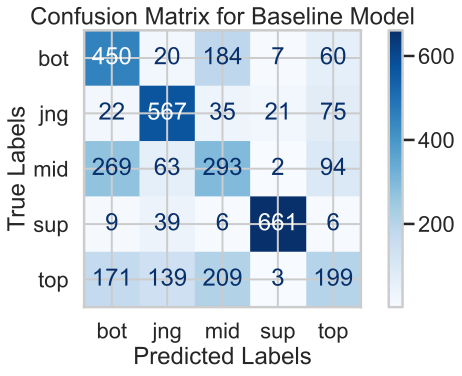

In [39]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred, labels=knn.classes_)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, 
                              display_labels=knn.classes_)
disp.plot(cmap=plt.cm.Blues)

# Add titles and labels
plt.title("Confusion Matrix for Baseline Model")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

## Step 7: Final Model

In [40]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report

# Ensure that 'features' and 'target' are correctly defined
features = [
    'damagetochampions', 'dpm', 'damageshare', 'damagetakenperminute',
    'wardsplaced', 'wpm', 'wardskilled', 'wcpm', 'controlwardsbought',
    'visionscore', 'vspm', 'totalgold', 'earnedgold', 'earned gpm',
    'earnedgoldshare', 'goldspent'
]
target = 'position'

# Separate features and target
X = player_df[features]
y = player_df[target]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Define the preprocessor for scaling
preprocessor = ColumnTransformer(
    transformers=[
        ('scaler', StandardScaler(), features)  # Apply scaling to all features
    ]
)

# Build the pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),  # Add preprocessor
    ('knn', KNeighborsClassifier())  # KNN classifier
])

# Define parameter grid for GridSearchCV
param_grid = {
    'knn__n_neighbors': [3, 5, 7, 9, 11],
    'knn__weights': ['uniform', 'distance'],
    'knn__metric': ['minkowski', 'manhattan']
}

# Initialize GridSearchCV
grid_search = GridSearchCV(
    pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1
)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Get the best parameters and best model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Evaluate the final model
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

# Display the results
print("Final Model Evaluation:")
print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Best Hyperparameters:", best_params)

Final Model Evaluation:
Accuracy: 0.78
Classification Report:
              precision    recall  f1-score   support

         bot       0.73      0.78      0.76       721
         jng       0.91      0.92      0.91       720
         mid       0.61      0.53      0.57       721
         sup       0.98      0.98      0.98       721
         top       0.67      0.70      0.68       721

    accuracy                           0.78      3604
   macro avg       0.78      0.78      0.78      3604
weighted avg       0.78      0.78      0.78      3604

Best Hyperparameters: {'knn__metric': 'manhattan', 'knn__n_neighbors': 11, 'knn__weights': 'distance'}


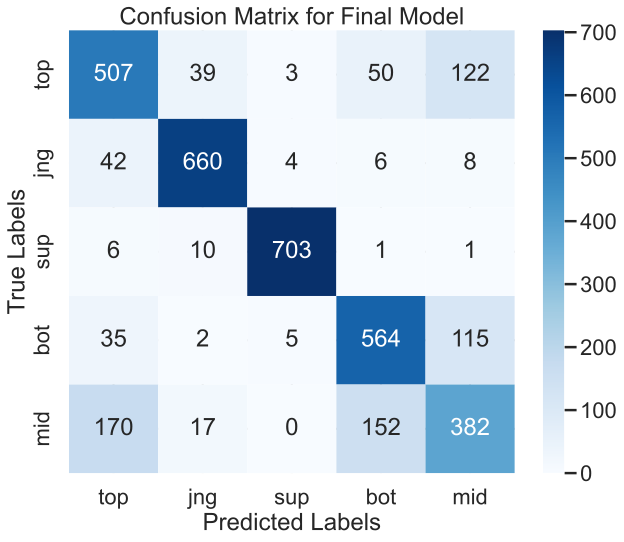

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred, labels=y_test.unique())

# Create a heatmap for the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(
    conf_matrix,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=y_test.unique(),
    yticklabels=y_test.unique()
)

plt.title('Confusion Matrix for Final Model')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

## Step 8: Fairness Analysis

In [42]:
player_df['is_lpl'] = (player_df['league'] == 'LPL')
player_df

position  damagetochampions      dpm  damageshare  ...  wardskilled  \
24          top            11188.0   491.78         0.28  ...          5.0   
25          jng             4426.0   194.55         0.11  ...         10.0   
26          mid            12577.0   552.84         0.31  ...          2.0   
...         ...                ...      ...          ...  ...          ...   
133579      mid            10486.0   349.53         0.13  ...          5.0   
133580      bot            33930.0  1131.00         0.43  ...          9.0   
133581      sup             3987.0   132.90         0.05  ...         20.0   

        wcpm  controlwardsbought  is_lpl  
24      0.22                 3.0    True  
25      0.44                 5.0    True  
26      0.09                 4.0    True  
...      ...                 ...     ...  
133579  0.17                 4.0   False  
133580  0.30                 5.0   False  
133581  0.67                11.0   False  

[18020 rows x 19 columns]

In [44]:
from sklearn.metrics import precision_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

# Define feature columns and target column
features = ['damagetochampions', 'dpm', 'damageshare', 
            'damagetakenperminute', 'wardsplaced', 'wpm', 
            'wardskilled', 'wcpm', 'controlwardsbought',
            'visionscore', 'vspm', 'totalgold', 'earnedgold', 
            'earned gpm', 'earnedgoldshare', 'goldspent']

target = 'position'


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(player_df[features],
                                                    player_df[target],
                                                    test_size=0.2,
                                                    random_state=42, 
                                                    stratify=y)

# Train the KNeighborsClassifier
knn_final = Pipeline([
    ('scaler', StandardScaler()), 
    ('knn', KNeighborsClassifier(n_neighbors=21))
])
knn_final.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('knn', KNeighborsClassifier(n_neighbors=21))])

In [45]:
test_df = X_test.copy()
test_df['position'] = y_test
test_df['is_LPL'] = player_df.loc[test_df.index, 'is_lpl']
test_df['pred'] = knn_final.predict(X_test)

In [46]:
# Separate LPL and non-LPL players in the test set
lpl_indices = test_df['is_LPL']
non_lpl_indices = (test_df['is_LPL'] == False)

# Precision calculation for LPL players in the test set
precision_lpl = precision_score(test_df.loc[lpl_indices, 'position'],
                                test_df.loc[lpl_indices, 'pred'],
                                average='weighted', zero_division=0)

# Precision calculation for non-LPL players in the test set
precision_non_lpl = precision_score(test_df.loc[non_lpl_indices, 
                                    'position'],
                                    test_df.loc[non_lpl_indices, 'pred'],
                                    average='weighted', zero_division=0)

# Calculate the observed difference in precision
observed_diff = precision_lpl - precision_non_lpl

print(f"Observed Precision Difference: {observed_diff:.4f}")

Observed Precision Difference: 0.0157


In [47]:
# Number of permutations
n_permutations = 1000
permuted_diffs = []

# Perform permutation test
for _ in range(n_permutations):
    # Shuffle predicted labels
    shuffled_labels = np.random.permutation(test_df['is_LPL'])
    
    # Split shuffled predictions into LPL and non-LPL
    shuffled_lpl = shuffled_labels
    shuffled_non_lpl = (shuffled_labels == False)
    
    # Calculate precision for shuffled groups
    precision_shuffled_lpl = precision_score(test_df.loc[shuffled_lpl, 
                                             'position'],
                                             test_df.loc[shuffled_lpl, 
                                             'pred'],
                                             average='weighted', 
                                             zero_division=0)
    
    precision_shuffled_non_lpl = precision_score(test_df
                                                 .loc[shuffled_non_lpl,
                                                 'position'],
                                                 test_df
                                                 .loc[shuffled_non_lpl,
                                                 'pred'],
                                                 average='weighted', 
                                                 zero_division=0)
    
    # Store the difference
    permuted_diff = precision_shuffled_lpl - precision_shuffled_non_lpl
    permuted_diffs.append(permuted_diff)

# Convert to NumPy array
permuted_diffs = np.array(permuted_diffs)

# Calculate p-value (two-tailed test)
p_value = (permuted_diffs >= observed_diff).mean()

# Print results
print(f"Observed Precision Difference: {observed_diff:.4f}")
print(f"P-value: {p_value:.4f}")

Observed Precision Difference: 0.0157
P-value: 0.1320


In [48]:
import plotly.graph_objects as go

# Assume observed_diff and permuted_diffs are already calculated
# observed_diff: observed difference in means
# permuted_diffs: array of permuted differences in means

# Create a histogram for the permuted differences
fig = go.Figure()

# Add the histogram of permuted differences
fig.add_trace(
    go.Histogram(
        x=permuted_diffs,  # Use the array of permuted differences here
        nbinsx=30,
        marker=dict(color="blue", opacity=0.7),
        name="Permuted Differences"
    )
)

# Add a vertical dashed line for the observed difference
fig.add_vline(
    x=observed_diff,  # Replace with your observed difference value
    line_dash="dash",
    line_color="red",
    annotation_text="Observed Difference",
    annotation_position="top right"
)

# Customize layout
fig.update_layout(
    title=\
"Empirical Distribution of Permuted Differences with Observed Difference",
    xaxis_title="Difference in Means",
    yaxis_title="Count",
    template="plotly_white",
    showlegend=False
)

# Show the figure
fig.show(renderer="iframe")

# Save the figure to an HTML file
fig.write_html("hypothesis_test_distribution.html", 
               include_plotlyjs='cdn')
